<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd 'gdrive/My Drive/Year4/Project/'

/content/gdrive/My Drive/Year4/Project


In [0]:
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [0]:
sys.path.append('/content/gdrive/My Drive/Year4/Project/local_modules')

In [0]:
case = ['Case1_2018_12_29_Camera1_Coor(1_1)','Case2_2018_12_30_Camera1_Coor(4_8)','Case4_2019_01_07_Camera2_Coor(1_4)',
        'Case6_2019_01_12_Camera2_Coor(4_9)','Case8_2018_10_10_Coor(5_4)','Case9_2018_10_05_Coor(1_4_3_6)','Case10_2018_09_29_Coor(5_2)']

rect_val = [(80,15,38,55,12,15),(80,15,38,55,12,15),(70,15,38,55,11,15),(70,15,38,55,11,15),(70,15,38,55,11,15),
            (70,15,40,55,11,15),(70,15,40,55,11,15)]

In [0]:
from preprocess import prep
pre = prep()
time1 = dict()
time1 = pre.get_time_series(case[-1],rect_val[-1])

getting...
['21-20-05.png', '21-20-15.png', '21-20-25.png', '21-20-35.png', '21-20-45.png']
.............................................................Case10_2018_09_29_Coor(5_2) complete


In [0]:
os.listdir('/content/gdrive/My Drive/Year4/Project/top_view')

['Case7_2018_10_02_Coor(5_9)',
 'Case10_2018_09_29_Coor(5_2)',
 'Case9_2018_10_05_Coor(1_4_3_6)',
 'Case1_2018_12_29_Camera1_Coor(1_1)',
 'Case5_2019_01_07_Camera1_Coor(1_8)',
 'Case4_2019_01_07_Camera2_Coor(1_4)',
 'Case3_2019_01_06_Camera2_Coor(3_2)',
 'Case2_2018_12_30_Camera1_Coor(4_8)',
 'Case6_2019_01_12_Camera2_Coor(4_9)',
 'Case8_2018_10_10_Coor(5_4)']

In [0]:
time1['A1'][0]

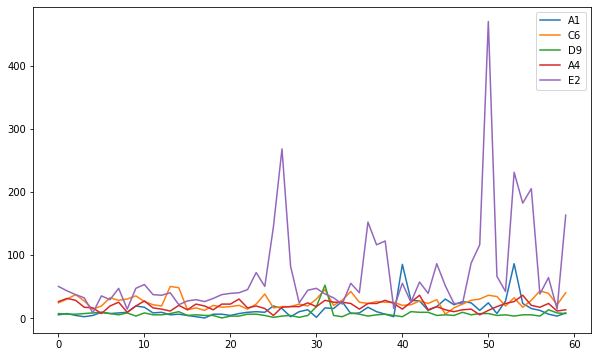

In [0]:
plt.figure(figsize=(10,6))
plt.plot(time1['A1'][0],label='A1')
plt.plot(time1['C6'][0],label='C6')
plt.plot(time1['D9'][0],label='D9')
plt.plot(time1['A4'][0],label='A4')
plt.plot(time1['E2'][0],label='E2')

plt.legend()


## Label

In [0]:
X = []
y = []

In [0]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

for key in time_series.keys():
  # tmp = np.array(time_series[key]).reshape(-1,1)
  # norm = StandardScaler().fit_transform(tmp)
  # X.append(norm)
  # tmp = time_series[key]
  # print(len(tmp))
  X.append(time_series[key])
  if(key == 'E2'):
    y.append(1)
  else:
    y.append(0)

In [0]:
# padding
from keras.preprocessing.sequence import pad_sequences

X_pad = []
max_len = -1
for x in X:
  # print(len(x))
  if(max_len < len(x)):
    max_len = len(x)

# for x in X:
  # if(len(x) < max_len):
X = pad_sequences(X,padding='post',maxlen = max_len, value=0)
# print(tmp)
# print(tmp.shape)

In [0]:
X = np.array(X)
y = np.array(y)

In [0]:
print(X.shape,y.shape)

(350, 226, 1) (350, 2, 2)


## Model

In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [0]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X.shape,y.shape)

(350, 226, 1) (350, 2, 2)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [0]:
print(X_train.shape,y_train.shape)

(280, 226, 1) (280, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 226, 50)           10400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 226, 50)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dropout_20 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

In [0]:
from sklearn.utils.class_weight import compute_class_weight

y_int = np.argmax(y_train,axis=1)
class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)

# class_weight = {0: 1.,
#                 1: 20.}
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X_train,y_train,epochs=50, validation_split=0.3, class_weight=class_weight)

Train on 196 samples, validate on 84 samples
Epoch 1/50
196/196 [==============================] - 7s 33ms/step - loss: 8.1448 - acc: 0.4949 - val_loss: 5.5810 - val_acc: 0.6548
Epoch 2/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1829 - acc: 0.5459 - val_loss: 9.0185 - val_acc: 0.4405
Epoch 3/50
196/196 [==============================] - 2s 11ms/step - loss: 7.9189 - acc: 0.5102 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 4/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1281 - acc: 0.5561 - val_loss: 7.2915 - val_acc: 0.5476
Epoch 5/50
196/196 [==============================] - 2s 11ms/step - loss: 7.1918 - acc: 0.5561 - val_loss: 7.8672 - val_acc: 0.5119
Epoch 6/50
196/196 [==============================] - 2s 11ms/step - loss: 8.3259 - acc: 0.4847 - val_loss: 6.9078 - val_acc: 0.5714
Epoch 7/50
196/196 [==============================] - 2s 11ms/step - loss: 6.8685 - acc: 0.5765 - val_loss: 6.9078 - val_acc: 0.5714
Epoch 8/50
196/196 [===

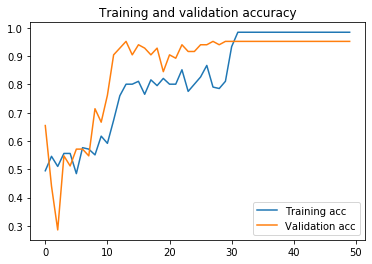

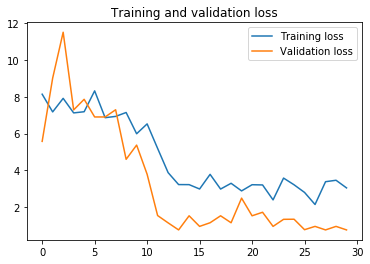

In [0]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predicted

In [0]:
for key in time_series.keys():
  print(key)

In [0]:
y_pred = model.predict_classes(X)

In [0]:
def print_output(y):
  for i in range(len(y)):
    print(y[i],end=' ')
    if((i+1)%5 == 0):
      print('\n')
print_output(y_pred)

0 1 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

1 0 0 0 0 

0 0 0 0 0 

0 0 1 0 0 

0 0 0 0 0 

0 0 0 1 0 

0 0 0 0 0 

0 0 0 0 0 



In [0]:
rect = []
series = dict()

START_X = 70
START_Y = 15
WIDTH = 40
HEIGHT = 55
DELTA_X = 51
DELTA_Y = 70
pos = ['A','B','C','D','E']

def draw_rect(img,time_series):
  for i in range(10):
    for j in range(5):
      x = START_X+(DELTA_X*i)
      y = START_Y+(DELTA_Y*j)

      cv.rectangle(img,(x,y),(x+WIDTH,y+HEIGHT),(0,255,0),1)j
for i in range(len(clean_data)):
  print('.',end='')
  tmp = np.array(clean_data[i])
  # tmp = np.array(data[i])
  draw_rect(tmp,series)
  rect.append(tmp)
plot_img(rect[0])

In [0]:
np.unique(y_train)

array([0., 1.], dtype=float32)